In [1]:
import pandas as pd
import numpy as np
import csv
import random
from collections import defaultdict
import math
import scipy.optimize
from sklearn import svm
import numpy
import string
import random
import string
from sklearn import linear_model, metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [296]:
# train = pd.read_csv('user_item_review_merge_table.csv')
train = pd.read_csv('merge_table_drop_na.csv')
train.head(5)

,user_id,item_id,playtime_forever,recommend
0,76561197970982479,22200,271,True
1,76561197970982479,1250,10006,True
2,76561197970982479,43110,834,True
3,js41637,227300,551,True
4,js41637,239030,349,True


In [3]:
def splitData(X, y, p1, p2): 
    X = np.array(X)
    y = np.array(y)
    sss = StratifiedShuffleSplit(n_splits=5, test_size=p1)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

    sss = StratifiedShuffleSplit(n_splits=5, test_size=p2)
    X = X_train
    y = y_train
    for train_index, test_index in sss.split(X, y):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]

    print(len(y_train), len(y_valid), len(y_test))
    return X_train, y_train, X_valid, y_valid, X_test, y_test
    

### Bought or NOT

In [4]:
def readCSV(path):
    with open(path, encoding="utf8") as f:
        f.readline()
        for l in f:
            u,i,t,_,_ = l.strip().split(',')
            t = int(t)
            yield u,i,t

In [5]:
timeX = []
for l in readCSV('user_item_review_merge_table.csv'):
    if l[2] < 1000 and l[2] > 0:
        timeX.append(l)
len(timeX)

2571484

In [6]:
n = 800000
random.shuffle(timeX)
timeX = timeX[:n]

In [11]:
times = [t for _,_,t in timeX]

In [12]:
D = [np.percentile(times,i) for i in [25,50,75]]
D

[28.0, 112.0, 316.0]

In [17]:
def mapping(x):
    for i in range(len(D)):
        if x <= D[i]:
            return i
    return len(D)

In [19]:
timey = list(map(mapping, times))
max(timey)

3

In [268]:
# random.shuffle(allData)

In [269]:
# allData = allData[:500000]

In [270]:
# p1 = round(len(allData)*.8)
# p2 = round(len(allData)*.9)
# p1,p2

(400000, 450000)

In [ ]:
# timeTrain = allData[:p1]
# timeValid = allData[p1:p2]
# timeTest = allData[p2:]

In [20]:
X_train, y_train, X_valid, y_valid, X_test, y_test = splitData(timeX, timey, .1, .15)

612000 108000 80000


In [21]:
timePerUser = defaultdict(list)
timePerItem = defaultdict(list)
for u,i,t in X_train:
    timePerUser[u].append((i,t))
    timePerItem[i].append((u,t))

In [22]:
N = len(X_train)
nUsers = len(timePerUser)
nItems = len(timePerItem)
users = list(timePerUser.keys())
items = list(timePerItem.keys())

In [25]:
timeMean = np.mean(y_train)
timeMed = np.median(y_train)
timeMean, timeMed

(1.497919934640523, 1.0)

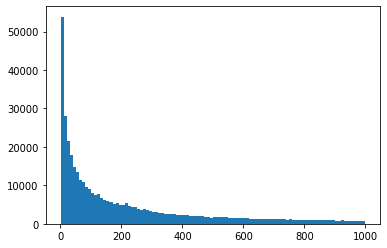

In [276]:
# times2 = [x for x in times if x > 0]
# x = plt.hist(times2, bins=100)

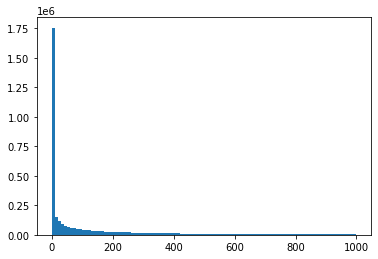

In [80]:
# times2 = [x for x in times if x < 1000 and x > 0]
# x = plt.hist(times2, bins=100)

In [26]:
alpha = timeMean # median might be better than mean
userBiases = defaultdict(float)
itemBiases = defaultdict(float)

In [37]:
def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def inner(x, y):
    return sum([a*b for a,b in zip(x,y)])

def prediction(user, item):
    global userGamma
    global itemGamma
    return alpha + userBiases[user] + itemBiases[item] + inner(userGamma[user], itemGamma[item])

def unpack(theta):
    global K
    global alpha
    global userBiases
    global itemBiases
    global userGamma
    global itemGamma
    index = 0
    alpha = theta[index]
    index += 1
    userBiases = dict(zip(users, theta[index:index+nUsers]))
    index += nUsers
    itemBiases = dict(zip(items, theta[index:index+nItems]))
    index += nItems
    for u in users:
        userGamma[u] = theta[index:index+K]
        index += K
    for i in items:
        itemGamma[i] = theta[index:index+K]
        index += K

def cost(theta, labels, lamb):
    global K
    unpack(theta)
    predictions = [prediction(d[0], d[1]) for d in X_train]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in users:
        cost += lamb*userBiases[u]**2
        for k in range(K):
            cost += lamb*userGamma[u][k]**2
    for i in items:
        cost += lamb*itemBiases[i]**2
        for k in range(K):
            cost += lamb*itemGamma[i][k]**2
    return cost

def derivative(theta, labels, lamb):
    global K
    unpack(theta)
    N = len(X_train)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    dUserGamma = {}
    dItemGamma = {}
    for u in timePerUser:
        dUserGamma[u] = [0.0 for k in range(K)]
    for i in timePerItem:
        dItemGamma[i] = [0.0 for k in range(K)]
    for d in X_train:
        u,i = d[0], d[1]
        pred = prediction(u, i)
        diff = pred - int(d[2])
        dalpha += 2/N*diff
        dUserBiases[u] += 2/N*diff
        dItemBiases[i] += 2/N*diff
        for k in range(K):
            dUserGamma[u][k] += 2/N*itemGamma[i][k]*diff
            dItemGamma[i][k] += 2/N*userGamma[u][k]*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
        for k in range(K):
            dUserGamma[u][k] += 2*lamb*userGamma[u][k]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
        for k in range(K):
            dItemGamma[i][k] += 2*lamb*itemGamma[i][k]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    for u in users:
        dtheta += dUserGamma[u]
    for i in items:
        dtheta += dItemGamma[i]
    return numpy.array(dtheta)

In [33]:
K = 0
lamb = 1e-5
iter = 50
userGamma = {}
itemGamma = {}

for u in timePerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in timePerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + # Initialize alpha
                                   [0.0]*(nUsers+nItems) + # Initialize beta
                                   [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))], # Gamma
                             derivative, 
                             args=(y_train, lamb), 
                             maxiter=iter, 
                             epsilon=1e-8)

MSE = 1.251357956169918
MSE = 2.3405443543450146
MSE = 1.3144862774054917
MSE = 1.257266449415934
MSE = 1.252274896859762
MSE = 1.2515368882643685
MSE = 1.2513950983907927
MSE = 1.2513657735763244
MSE = 1.2513596064025336
MSE = 1.2513583047492625
MSE = 1.2513580298113205
MSE = 1.2513579717296293
MSE = 1.2513579594595947
MSE = 1.2513579568596789
MSE = 1.2513579563117518
MSE = 1.2513579562092367
MSE = 1.2513579561738315
MSE = 1.2513579561722856
MSE = 1.2513579561746717
MSE = 1.2513579561746546
MSE = 1.251357956174884


(array([1.54245304, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]),
 1.251357956174884,
 {'grad': array([-4.24958728e+02, -3.86110340e-02, -3.77475644e-02, ...,
         -6.12606363e-04, -2.03090702e-03, -1.38750153e-04]),
  'task': 'ABNORMAL_TERMINATION_IN_LNSRCH',
  'funcalls': 21,
  'nit': 0,
  'warnflag': 2})

In [38]:
yPred = []
for u,i,r in X_valid:
    try:
        yPred.append(prediction(u,i))
    except:
        yPred.append(alpha)

validMSE = MSE(yPred,y_valid)
validMSE

1.25136803756458

In [39]:
K = 2
lamb = 1e-5
iter = 50

userGamma = {}
itemGamma = {}

for u in timePerUser:
    userGamma[u] = [random.random() * 0.1 - 0.05 for k in range(K)]
for i in timePerItem:
    itemGamma[i] = [random.random() * 0.1 - 0.05 for k in range(K)]

scipy.optimize.fmin_l_bfgs_b(cost, [alpha] + # Initialize alpha
                                   [0.0]*(nUsers+nItems) + # Initialize beta
                                   [random.random() * 0.1 - 0.05 for k in range(K*(nUsers+nItems))], # Gamma
                             derivative, 
                             args=(y_valid, lamb), 
                             maxiter=iter, 
                             epsilon=1e-8)

MSE = 1.2513683690656763
MSE = 2.341695686059443
MSE = 1.3147362647465435
MSE = 1.2573274538311132
MSE = 1.252295996992673
MSE = 1.2515495585536913
MSE = 1.251405988070957
MSE = 1.2513762871705467
MSE = 1.2513700405649317
MSE = 1.2513687221353103
MSE = 1.2513684436541015
MSE = 1.2513683848234367
MSE = 1.2513683723947135
MSE = 1.251368369768964
MSE = 1.2513683692142406
MSE = 1.25136836909705
MSE = 1.2513683690723016
MSE = 1.2513683690670792
MSE = 1.2513683690659603
MSE = 1.2513683690657396
MSE = 1.2513683690656876


(array([ 1.54245304,  0.        ,  0.        , ..., -0.00592699,
         0.02992846,  0.03366071]),
 1.252494144281765,
 {'grad': array([-4.24958727e+02, -3.86110448e-02, -3.77476017e-02, ...,
          4.89392159e-05, -3.98625171e-06,  4.54244859e-06]),
  'task': 'ABNORMAL_TERMINATION_IN_LNSRCH',
  'funcalls': 21,
  'nit': 0,
  'warnflag': 2})

In [40]:
yPred = []
for u,i,r in X_valid:
    try:
        yPred.append(prediction(u,i))
    except:
        yPred.append(alpha)

validMSE = MSE(yPred,y_valid)
validMSE

1.2513781042437102

In [44]:
predictions = open("predictions_time.csv", 'w')
predictions.write('User,\tItem,\tPred,\tTrue'+ '\n')
for u,i,r in X_test:
    try:
        pred = prediction(u, i)
    except:
        pred = alpha
    # print(pred)
    predictions.write(u + ',\t' + i + ',\t' + str(pred) + ',\t' + str(mapping(int(r))) + '\n')
    
predictions.close()

### PlayafterBuy or NOT

In [389]:
def readCSV2(path):
    with open(path, encoding="utf8") as f:
        f.readline()
        for l in f:
            u,i,_,p,_ = l.strip().split(',')
            p = 1 if p == 'True' else 0
            yield u,i,p

In [211]:
def Jaccard(s1, s2):
    return len(s1.intersection(s2))/len(s1.union(s2))

In [384]:
def prepare(Train):
    item0Count = defaultdict(int)
    item1Count = defaultdict(int)
    total0 = 0
    total1 = 0
    item0PerUser = defaultdict(set)
    item1PerUser = defaultdict(set)
    userPerItem0 = defaultdict(set)
    userPerItem1 = defaultdict(set)
    item0Set = set()
    item1Set = set()

    for u,i,p in Train:    
        if int(p):
            item1Count[i] += 1
            total1 += 1
            item1Set.add(i)
            item1PerUser[u].add(i)
            userPerItem1[i].add(u)
        else:
            item0Count[i] += 1
            total0 += 1
            item0Set.add(i)
            item0PerUser[u].add(i)
            userPerItem0[i].add(u)
            
    mostPopular0 = [(item0Count[x], x) for x in item0Count]
    mostPopular1 = [(item1Count[x], x) for x in item1Count]
    mostPopular0.sort()
    mostPopular0.reverse()
    mostPopular1.sort()
    mostPopular1.reverse()

    return mostPopular0, mostPopular1, item0PerUser, item1PerUser, userPerItem0, userPerItem1

In [391]:
playX = []
for l in readCSV2('user_item_review_merge_table.csv'):
    playX.append(l)
len(playX)

5154633

In [392]:
n = 800000
random.shuffle(playX)
playX = playX[:n]


In [393]:
playy = [t for _,_,t in playX]

In [394]:
X_train, y_train, X_valid, y_valid, X_test, y_test = splitData(playX, playy, .1, .15)

612000 108000 80000


In [395]:
mostPopular0, mostPopular1, game0PerUser, game1PerUser, userPerGame0, userPerGame1 = prepare(X_train)

In [396]:
len(set(mostPopular0)), len(set(mostPopular1))

(7528, 7412)

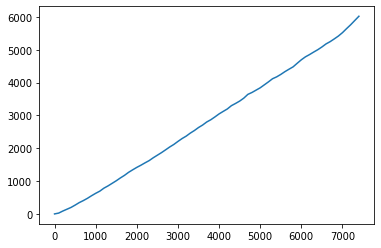

In [397]:
x = [i for i in range(1, min([len(set(mostPopular0)), len(set(mostPopular1))]), 100)]
y = []
for n in x:
    y.append(len(set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])))

plt.plot(x,y)

In [398]:
def getPred(X, thres1, output=False):
    yPred = []
    n = round(min([len(set(mostPopular0)), len(set(mostPopular1))])*thres1)
    union = set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])
    popularSet0 = set([x[1] for x in mostPopular0[:n]]) - union
    popularSet1 = set([x[1] for x in mostPopular1[:n]]) - union

    l = len(X)
    cnt = 0
    for u,i,_ in X:
        cnt += 1

        if i in popularSet0:
            yPred.append(0)
            continue
        
        if i in popularSet1:
            yPred.append(1)
            continue
        
        maxSimilarity0 = 0
        gSet = set(userPerGame0[i])
        for g_prime in game0PerUser[u]:
            g_priSet = set(userPerGame0[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity0 = max(maxSimilarity0, similarity)
        
        maxSimilarity1 = 0
        gSet = set(userPerGame1[i])
        for g_prime in game1PerUser[u]:
            g_priSet = set(userPerGame1[g_prime])
            similarity = Jaccard(gSet, g_priSet)
            maxSimilarity1 = max(maxSimilarity1, similarity)
        # print(maxSimilarity0 , maxSimilarity1)
        if maxSimilarity0 > maxSimilarity1:
            yPred.append(0)
            continue
      
        yPred.append(1)

        if output and cnt%1000 == 0:
            print(cnt, '/', l)

    return yPred

In [399]:
thres1 = .025
pred = getPred(X_valid, thres1, output=True)

3000 / 108000
4000 / 108000
6000 / 108000
8000 / 108000
10000 / 108000
13000 / 108000
15000 / 108000
18000 / 108000
22000 / 108000
27000 / 108000
29000 / 108000
31000 / 108000
33000 / 108000
34000 / 108000
35000 / 108000
36000 / 108000
37000 / 108000
39000 / 108000
41000 / 108000
45000 / 108000
50000 / 108000
51000 / 108000
55000 / 108000
56000 / 108000
57000 / 108000
60000 / 108000
61000 / 108000
62000 / 108000
63000 / 108000
64000 / 108000
65000 / 108000
67000 / 108000
69000 / 108000
70000 / 108000
71000 / 108000
73000 / 108000
77000 / 108000
80000 / 108000
83000 / 108000
85000 / 108000
91000 / 108000
93000 / 108000
95000 / 108000
97000 / 108000
98000 / 108000
101000 / 108000
102000 / 108000
104000 / 108000
107000 / 108000
108000 / 108000


In [400]:
acc = metrics.accuracy_score(y_valid, pred)
TN, FP, FN, TP = confusion_matrix(y_valid, pred).ravel()
print('acc: ', acc)
print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres1)

acc:  0.7426111111111111
TN:  26770 FP: 12376 FN:  15422 TP:  53432  |  thres:  0.025


In [403]:
thresLst = [.01,.05,.1,.3,.5,.7,.9]
print('-'*30+'PlayafterBuy or NOT'+'-'*30)
for thres in thresLst:
    pred = getPred(X_valid, thres)
    acc = metrics.accuracy_score(y_valid, pred)
    TN, FP, FN, TP = confusion_matrix(y_valid, pred).ravel()
    print('Acc: ', acc)
    print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres)


------------------------------PlayafterBuy or NOT------------------------------
Acc:  0.737175925925926
TN:  27315 FP: 11831 FN:  16554 TP:  52300  |  thres:  0.01
Acc:  0.7420925925925926
TN:  25465 FP: 13681 FN:  14173 TP:  54681  |  thres:  0.05
Acc:  0.740574074074074
TN:  24363 FP: 14783 FN:  13235 TP:  55619  |  thres:  0.1
Acc:  0.7303240740740741
TN:  24038 FP: 15108 FN:  14017 TP:  54837  |  thres:  0.3
Acc:  0.7245462962962963
TN:  23969 FP: 15177 FN:  14572 TP:  54282  |  thres:  0.5
Acc:  0.7228240740740741
TN:  23967 FP: 15179 FN:  14756 TP:  54098  |  thres:  0.7
Acc:  0.7223611111111111
TN:  24019 FP: 15127 FN:  14858 TP:  53996  |  thres:  0.9


In [262]:
thres = .05
pred = getPred(X_test, thres)
acc = metrics.accuracy_score(y_test, pred)
TN, FP, FN, TP = confusion_matrix(y_test, pred).ravel()
print('acc: ', acc)
print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres)

acc:  0.73302
TN:  11054 FP: 7067 FN:  6282 TP:  25597  |  thres:  0.05


### Recommend or NOT

In [404]:
def readCSV3(path):
    with open(path, encoding="utf8") as f:
        f.readline()
        for l in f:
            u,i,_,r = l.strip().split(',')
            r = 1 if r == 'True' else 0
            yield u,i,r

In [405]:
recX = []
recy = []
for l in readCSV3('merge_table_drop_na.csv'):
    recX.append(l)
    recy.append(l[2])
len(recy)

46317

In [406]:
X_train, y_train, X_valid, y_valid, X_test, y_test = splitData(recX, recy, .1, .15)

35432 6253 4632


In [407]:
X_train

array([['76561198088807138', '49520', '1'],
       ['CriticalTiming', '250600', '1'],
       ['76561198051096646', '212200', '0'],
       ...,
       ['blackviper8881', '4000', '1'],
       ['76561198073808757', '230410', '0'],
       ['PuppyxKitten', '262060', '1']], dtype='<U32')

In [408]:
sum(np.array(recy))/len(recy)

0.8889176760152859

In [409]:
mostPopular0, mostPopular1, game0PerUser, game1PerUser, userPerGame0, userPerGame1 = prepare(X_train)

In [410]:
len(set(mostPopular0)), len(set(mostPopular1))

(1087, 2536)

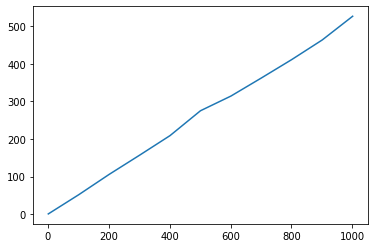

In [411]:
x = [i for i in range(1, min([len(set(mostPopular0)), len(set(mostPopular1))]), 100)]
y = []
for n in x:
    y.append(len(set([x[1] for x in mostPopular0[:n]]) & set([x[1] for x in mostPopular1[:n]])))

plt.plot(x,y)

In [412]:
thresLst = [.01,.05,.1,.3,.5,.7,.9]
print('-'*30+'Recommend or NOT'+'-'*30)
for thres in thresLst:
    pred = getPred(X_valid, thres)
    acc = metrics.accuracy_score(y_valid, pred)
    TN, FP, FN, TP = confusion_matrix(y_valid, pred).ravel()
    print('acc: ', acc)
    print('TN: ', TN, 'FP:', FP, 'FN: ', FN, 'TP: ', TP, ' | ', 'thres: ', thres)

------------------------------Recommend or NOT------------------------------
acc:  0.8795778026547257
TN:  92 FP: 603 FN:  150 TP:  5408  |  thres:  0.01
acc:  0.8695026387334079
TN:  160 FP: 535 FN:  281 TP:  5277  |  thres:  0.05
acc:  0.8706221013913321
TN:  160 FP: 535 FN:  274 TP:  5284  |  thres:  0.1
acc:  0.8717415640492564
TN:  117 FP: 578 FN:  224 TP:  5334  |  thres:  0.3
acc:  0.8760594914441068
TN:  107 FP: 588 FN:  187 TP:  5371  |  thres:  0.5
acc:  0.8813369582600352
TN:  88 FP: 607 FN:  135 TP:  5423  |  thres:  0.7
acc:  0.8818167279705741
TN:  89 FP: 606 FN:  133 TP:  5425  |  thres:  0.9
